Created 8/10/2025 <br>
Written by Shawn Newman (With code stolen from Steven Corum and Alex Seaver)

In [198]:
import matplotlib.pyplot as plt  # Plotting graphs and visualizing data
from matplotlib.ticker import LogLocator # Used for ticks in logarithmic plots
import numpy as np               # Numerical operations, particularly with arrays
import pandas as pd              # Data manipulation and analysis

import os
import importlib.util
quiet=True
current_dir = "."
target_file = "ICASL.py"
target_name = "ICASL"
while True:
    if not quiet: print(current_dir)
    # Check if ICASL is in the current directory
    ICASL_path = os.path.join(current_dir, target_file)
    if not quiet: print(ICASL_path)
    if os.path.isfile(ICASL_path):
        # Loads ICASL.py
        spec = importlib.util.spec_from_file_location(target_name, ICASL_path)
        ICASL = importlib.util.module_from_spec(spec)
        spec.loader.exec_module(ICASL)
        break
    else:
        # Move one level up
        parent_dir = os.path.join(current_dir, "..")
        if not quiet: print(parent_dir)
        if current_dir == parent_dir:  # Reached the root directory
            raise ValueError("ICASL.py not found")
        else:
            current_dir = parent_dir
ICASL.test()

sim_dir = "Sim_Data"
tran_dir = os.path.join(sim_dir, "Transient_Sims")
VREF_data, [temps, VREFs] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_VREF.csv"), ["Temp", "VREF"], new_x_label = "time", new_y_label = "VREF")
VOUT_data, [temps, VREFs] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_VOUT.csv"), ["Temp", "VREF"], new_x_label = "time", new_y_label = "VOUT")
IL_data, [temps] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_IL.csv"), ["Temp"], new_x_label = "time", new_y_label = "IL")
IQ_data, [VREFs] = ICASL.read_cadence_csv(os.path.join(tran_dir, "TI_RLDO_IQ.csv"), ["VREF"], new_x_label = "temp", new_y_label = "IQ")

# Example data structure usage:
VOUT_data[27][0.6] # This outputs a 2 column dataframe for temp=27 and VREF=0.6. Those columns were renamed to "time" and "VREF".

ICASL is loaded!
Layer 1 of keys for Temp: [27, 125, -55, -180]
Layer 2 of keys for VREF: [0.6, 0.7, 0.8, 0.9, 1.0]
Final dataframe columns: ['time', 'VREF']

Layer 1 of keys for Temp: [27, 125, -55, -180]
Layer 2 of keys for VREF: [0.6, 0.7, 0.8, 0.9, 1.0]
Final dataframe columns: ['time', 'VOUT']

Layer 1 of keys for Temp: [-180, -55, 27, 125]
Final dataframe columns: ['time', 'IL']

Layer 1 of keys for VREF: [0.6, 0.7, 0.8, 0.9, 1.0]
Final dataframe columns: ['temp', 'IQ']



,time,VOUT
0,0.000000e+00,-0.509838
1,5.000000e-09,-0.509838
2,5.004490e-09,-0.509839
3,5.008125e-09,-0.509840
4,5.010122e-09,-0.509840
...,...,...
2076,2.030791e-05,0.609046
2077,2.051343e-05,0.609046
2078,2.072343e-05,0.609046
2079,2.086172e-05,0.609046


In [ ]:
# Determines coordinates of peak
def tran_peak(times, values, settling_direction, log=False):
    if (settling_direction.lower() in ["up", "rising"]): peak_value = min(values)
    elif (settling_direction.lower() in ["down", "falling"]): peak_value = max(values)
    peak_time = times[np.where(values == peak_value)[0]][0]
    if log:
        print(f"Peak Time: {peak_time}")
        print(f"Peak Value: {peak_value}")
    return peak_time, peak_value

# Determines coordinates where transient is officially settled
def tran_settle(times, values, peak_value, settling_threshold, log=False):
    settled_value = np.mean(values[-3:-1])
    threshold = abs(peak_value*settling_threshold)
    # These are the indices of every piece of data whose y value is not within the settled threshold
    unsettled_indices = np.where(np.logical_or(values > settled_value+threshold, values < settled_value-threshold))[0]
    if len(unsettled_indices) == 0: 
        print("Error: Signal is always settled.")
        settled_time = times[0]
    else:
        last_unsettled_time = times[unsettled_indices[-1]]
        if log: print(f"Last Unsettled Time: {last_unsettled_time}")
        if times[-1] != last_unsettled_time:
            settled_time = times[unsettled_indices[-1]+1] # If your data range is too narrow and signal is oscillating, this may run while unsettled.
        else:
            print("Warning: Not settled by final time")
            settled_time = times[-1]
    if log:
        print(f"Settled Value: {settled_value}")
        print(f"Unsettled Indices: {unsettled_indices}")
        print(f"Unsettled Times: {times[unsettled_indices]}")
        print(f"Unsettled Values: {values[unsettled_indices]}")
        print(f"Within Threshold Times: {np.array([x for x in times if x not in times[unsettled_indices]])}")
        print(f"Within Threshold Values: {np.array([x for x in values if x not in values[unsettled_indices]])}")
        print(f"Settled Time: {settled_time}")
    return settled_time, settled_value

# Determines coordinates where transient first begins
def tran_start(times, values, log=False):
    # I thought it'd be fun to detect the start of transients (although definitely unnecessary) - I trace through each time step, finding the 
    # standard deviation shortly before and after, then take a ratio of those two stds. This ratio is within 20 and .05 everywhere 
    # except around start of the transient, where it spikes to the 1,000's (with interpolation, stays within 5 and .2 and spikes to 1,000,000s)
    # To find the exact point where the transient begins, I find the maximum drop in this ratio from one time step to the next. 
    std_ratios = []
    drops = []
    std_width = 10
    if (len(values) < 30):
        print("Error: only {len(values)} data points. Cannot compute transient calculations.")
        starting_time = 0
        starting_value = 0
    else:
        for i, value, time in zip(range(len(values)), values, times):
            if (i < std_width or i+std_width >= len(values)): std_ratios.append(1) ; drops.append(1) ; continue
            if (values[i-std_width] == values[i-std_width+1]): std_ratios.append(1) ; drops.append(1) ; continue
            if (values[i+std_width] == values[i+std_width-1]): std_ratios.append(1) ; drops.append(1) ; continue
            past_std = np.std(values[i-std_width:i])
            future_std = np.std(values[i:i+std_width])
            std_ratio = future_std/past_std
            std_ratios.append(std_ratio)
            drops.append(std_ratios[i-1]/std_ratios[i])
            if log: print(f"Index {i} : Time {time}: Value {value} : Ratio {future_std/past_std}")
        starting_time = times[drops.index(max(drops))-2]
        starting_value = values[np.where(times == starting_time)[0]][0]
    if log:
        print(f"Starting Value: {starting_value}")
        print(f"Starting Time: {starting_time}")
    return starting_time, starting_value

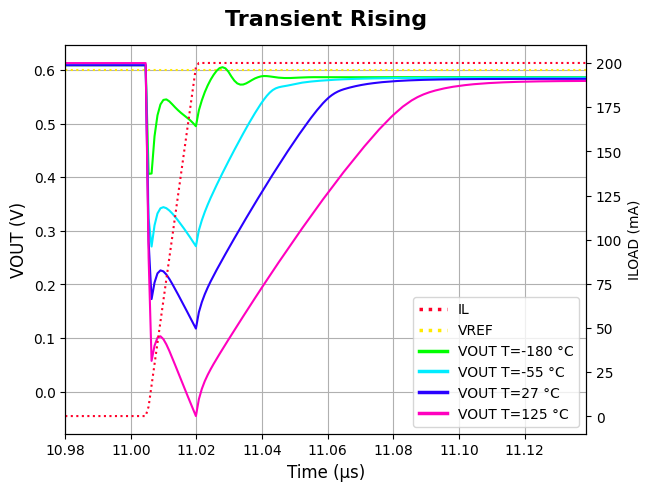

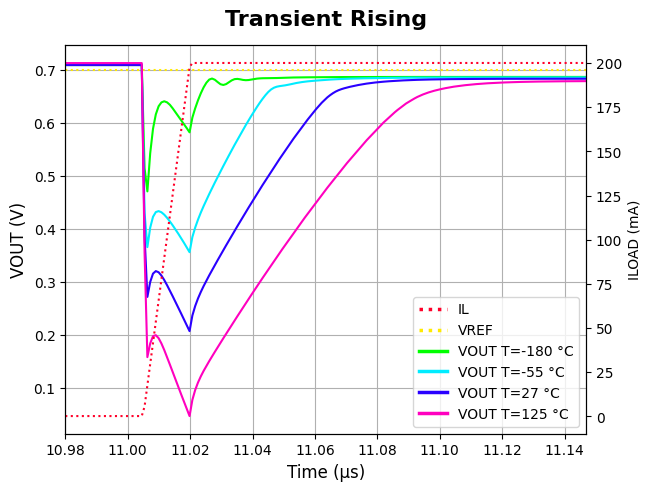

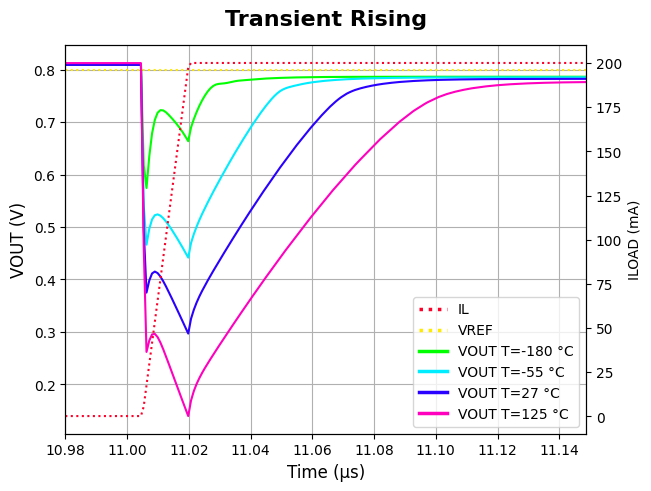

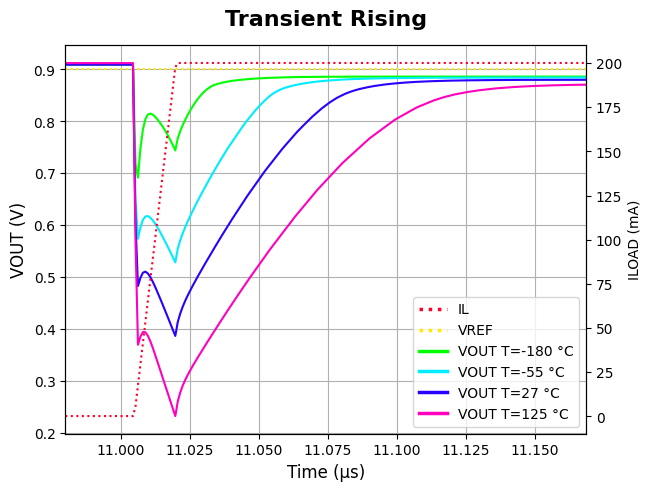

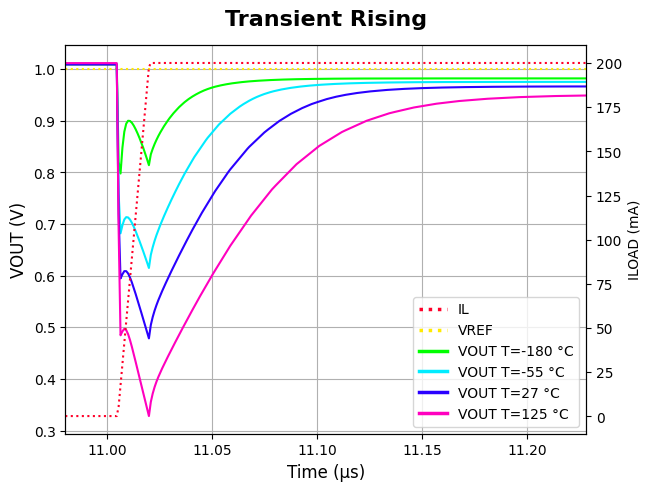

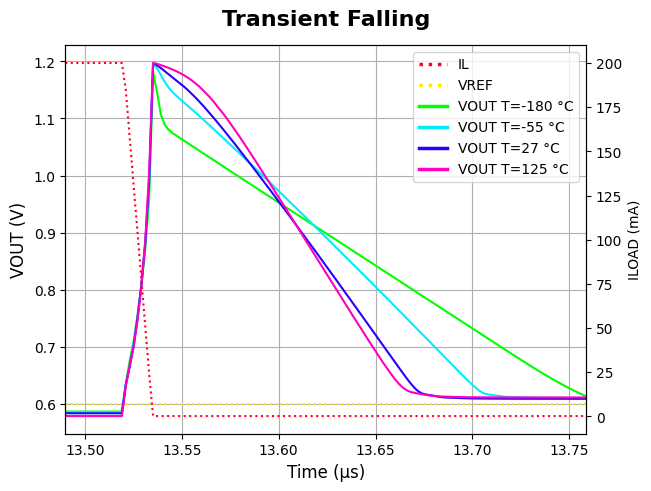

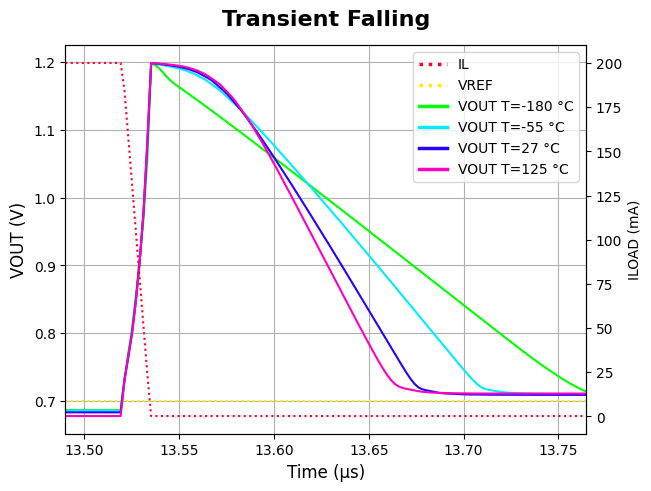

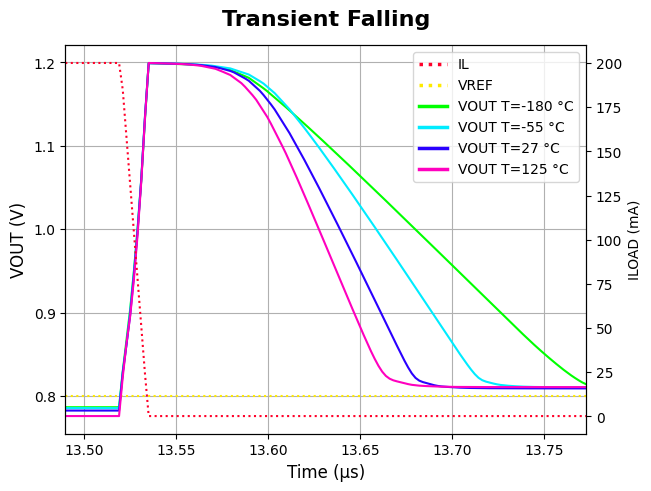

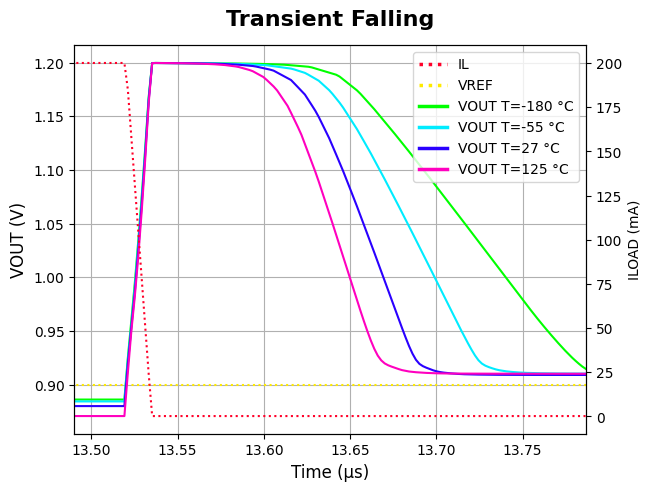

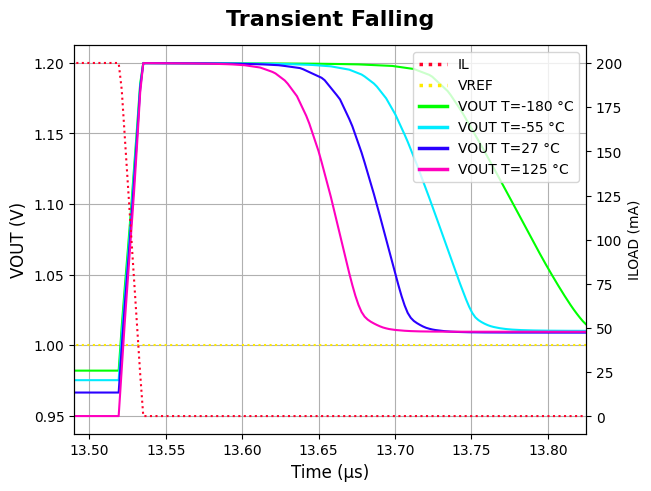

In [ ]:
def transient_plot(start_data, end_data, start_plot, legend_location, type, log=False):
    ts = 1e-6 # Time scale
    settling_threshold = .005
    start_data = start_data*ts
    end_data = end_data*ts
    metrics = []
    for VREF in VREFs:
        # Plot VREF
        VREF_df = VREF_data[27][VREF]                                                         # Obtains desired VREF dataframe at 27 degrees
        VREF_df = ICASL.limit_data(VREF_df, "time", start_data, end_data)                     # Cuts off data outside provided bounds
        fig, ax1 = ICASL.start_plot(f"Transient {type}", f"Time (µs)", "VOUT (V)", style="b") # Default plot creation/styling
        ax2 = ax1.twinx()                                                                     # Adds current axis on right side
        ax1.ticklabel_format(useOffset=False)                                                 # Gets rid of automatic offset for all x values
        t = np.linspace(start_data, end_data, 1000)                                           # Creates a new set of 1000 times across data range
        inter_VREF = np.interp(t, VREF_df["time"], VREF_df["VREF"])             # Interpolates (linearly) to fill this new time range with data
        ax1.plot(t/ts, inter_VREF, label=f"VREF", linestyle='dotted')

        # Plot IL
        IL_df = IL_data[27]
        IL_df = ICASL.limit_data(IL_df, "time", start_data, end_data)
        inter_IL = np.interp(t, IL_df["time"], IL_df["IL"])
        ax2.set_ylabel(f"ILOAD ({ICASL.prefix(IL_df['IL'])}A)")                 # Current's Engineering Notation prefix is automatically determined
        ax2.plot(t/ts, ICASL.scale(inter_IL), label=f"IL", linestyle='dotted')  # Current scaled between 1-999 for Engineering Notation

        settled_times = [] # Used for determining x limit
        for temp in temps:
            # Plot VOUT
            VOUT_df = VOUT_data[temp][VREF]
            VOUT_df = ICASL.limit_data(VOUT_df, "time", start_data, end_data)
            inter_VOUT = np.interp(t, VOUT_df["time"], VOUT_df["VOUT"])
            ax1.plot(t/ts, inter_VOUT, label=f"VOUT T={temp} °C")

            # Finding desired data points
            peak_time, peak_value = tran_peak(t, inter_VOUT, type, log=log)
            settled_time, settled_value = tran_settle(t, inter_VOUT, peak_value, settling_threshold, log=log)
            starting_time, starting_value = tran_start(t, inter_VOUT, log=log)

            # Store
            settled_times.append(settled_time)

            # Calcs
            IQ_df = IQ_data[VREF]
            IQ = IQ_df[IQ_df["temp"] == temp]["IQ"].values[0]
            #print(IQ)
            c_total = 14e-12
            io_max = .2
            delta_t_edge = 15e-9
            delta_v = peak_value-starting_value
            settling_time = settled_time-starting_time
            FOM1 = (c_total*delta_v/io_max) * (IQ/io_max)
            FOM2 = (delta_t_edge/1e-12) * (delta_v*IQ/io_max)
            metrics.append({
                'TYPE': type,
                'VREF': VREF,
                'TEMP_C': temp,
                'DELTA_VOUT_V': delta_v,
                'SETTLING_TIME': settling_time,
                'FOM1': FOM1,
                'FOM2': FOM2,
                'IQ': IQ,
            })
        
        ax1.set_xlim(start_plot, max(settled_times)/ts)
        #ax1.set_xlim(start_plot, end_data) 
        ICASL.finish_plot(fig, [ax2,ax1], save_dir="Sim_Plots", save_file=f"Tran_{type}_VREF={VREF}V.png", cm=plt.get_cmap('gist_rainbow'), 
                        show=True, legend_style=f"ck{legend_location}")
    return metrics

log = False
m1 = transient_plot(10.5, 11.4, 10.98, "lr", "Rising", log=log)
m2 = transient_plot(11.99, 14, 13.49, "ur", "Falling", log=log)

pd.DataFrame(m1+m2).to_csv('transient_metrics.csv', index=False, float_format='%.4g')